# CRSS 2018 data analysis 

Objective: 
#1) traffic accident statistics of CRSS 2018 data file
#2) creating a model to predict the maximum injury severity in an accident, which can be a criteria of how dangerous an accident is
#3) creating a model to predict whether a person will be hurt during the accident

In [43]:
# import packages
import pandas as pd
import geopandas as gpd
import numpy as np
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
import matplotlib.pyplot as plt
%matplotlib  inline
import seaborn as sns; sns.set(color_codes=True)
import urllib.request
from shapely.geometry import Point
from pandas.io.json import json_normalize
import sklearn
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import preprocessing 
import sklearn.feature_selection

                        Objective 1: Basic Statistics and informative graphs from the data

In [90]:
#importing data
ACCIDENT = pd.read_csv ('ACCIDENT.csv')
ACCIDENT.shape #This data has 48443 rows and 51 columns. 

(48443, 51)

In [91]:
ACCIDENT.columns

Index(['CASENUM', 'REGION', 'PSU', 'PJ', 'PSU_VAR', 'URBANICITY', 'STRATUM',
       'VE_TOTAL', 'VE_FORMS', 'PVH_INVL', 'PEDS', 'PERMVIT', 'PERNOTMVIT',
       'NUM_INJ', 'MONTH', 'YEAR', 'DAY_WEEK', 'HOUR', 'MINUTE', 'HARM_EV',
       'ALCOHOL', 'MAX_SEV', 'MAN_COLL', 'RELJCT1', 'RELJCT2', 'TYP_INT',
       'WRK_ZONE', 'REL_ROAD', 'LGT_COND', 'WEATHER1', 'WEATHER2', 'WEATHER',
       'SCH_BUS', 'INT_HWY', 'CF1', 'CF2', 'CF3', 'WKDY_IM', 'HOUR_IM',
       'MINUTE_IM', 'EVENT1_IM', 'MANCOL_IM', 'RELJCT1_IM', 'RELJCT2_IM',
       'LGTCON_IM', 'WEATHR_IM', 'MAXSEV_IM', 'NO_INJ_IM', 'ALCHL_IM',
       'PSUSTRAT', 'WEIGHT'],
      dtype='object')

Explanations of variables:
#CASENUM: CASE ID (Not a variable)
VE_TOTAL: Number of Total Motor Vehicles involved in the crash

VE_FORMS: Number of Motor Vehicles in Transport involved in the crash

PVH_INVL: Number of Parked/Working Vehicles involved in the crash

PEDS: Number of Persons Not in Motor Vehicles

PERMVIT: Number of Persons in Motor Vehicles in Transport

PERNOTMVIT: Number of Persons Not in Motor Vehicles in Transport

#NUM_INJ: Number Injured in Crash (Use imputed data)

#MONTH: Month of Crash (Use imputed data)

#YEAR: Year of Crash (Not a variable, all 2018)

#DAY_WEEK: Day of Week (Use imputed data)

#HOUR: Hour of Crash (Use imputed data)

#MINUTE: Minute of Crash (Use imputed data)

#HARM_EV: First Harmful Event (Use imputed data)

#ALCOHOL: Alcohol Involved in Crash (Use imputed data)

#MAX_SEV: Maximum Injury Severity in Crash (Use imputed data)

#MAN_COLL: Manner of Collision (Use imputed data)

#RELJCT1: Relation to Junction- Within Interchange Area (Use imputed data)

#RELJCT2: Relation to Junction- Specific Location (Will not use this)

#TYP_INT: Type of Intersection (Will not use this)

#WRK_ZONE: Work Zone (Will not use this)

#REL_ROAD: Relation to Trafficway (Will not use this)

#LGT_COND: Light Condition (Use imputed data)

#WEATHER: Atmospheric Conditions (Use imputed data)

#SCH_BUS: School Bus Related (Will not use this)

#INT_HWY: Interstate Highway (Will not use this)

#CF: Related Factors- Crash Level (Will not use this)

WKDY_IM: Imputed Day of Week

HOUR_IM: Imputed Hour of Crash

MINUTE_IM: Imputed Minute of Crash

EVENT1_IM: Imputed First Harmful Event

MANCOL_IM: Imputed Manner of Collision

RELJCT1_IM: Imputed Relation to Junction- Within Interchange Area

RELJCT2_IM: Imputed Relation to Junction- Specific Location

LGTCON_IM: Imputed Light Condition

WEATHR_IM: Imputed Atmospheric Conditions

MAXSEV_IM: Imputed Maximum Injury Severity in Crash

NO_INJ_IM: Imputed Number Injured in Crash

ALCHL_IM: Imputed Alcohol Involved in Crash

#WEIGHT :Weight of the case (Not a variable)

In [92]:
# Apply weights to ensure unbiased and robust estimate, here we use pd.sample method to randomly select case in ACCIDENT file with weights applied
# 484430 cases are selected randomly
# reference: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html
ACCIDENT_WEIGHT = ACCIDENT.sample(frac =10, weights=ACCIDENT['WEIGHT'], replace=True, random_state=420)
ACCIDENT_WEIGHT.describe().T

,count,mean,std,min,25%,50%,75%,max
CASENUM,484430.0,2.018009e+11,277279.345555,2.018000e+11,2.018010e+11,2.018010e+11,2.018010e+11,2.018010e+11
REGION,484430.0,2.703090e+00,0.889790,1.000000e+00,2.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00
PSU,484430.0,4.761269e+01,19.741105,1.000000e+01,3.200000e+01,4.800000e+01,6.300000e+01,8.300000e+01
PJ,484430.0,1.401873e+03,1061.345296,4.500000e+01,4.570000e+02,1.098000e+03,2.091000e+03,4.125000e+03
PSU_VAR,484430.0,5.132866e+01,31.646421,1.000000e+01,3.200000e+01,4.800000e+01,6.500000e+01,2.140000e+02
URBANICITY,484430.0,1.230322e+00,0.421040,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00
STRATUM,484430.0,8.593083e+00,1.709617,2.000000e+00,8.000000e+00,9.000000e+00,1.000000e+01,1.000000e+01
VE_TOTAL,484430.0,1.857924e+00,0.589650,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.500000e+01
VE_FORMS,484430.0,1.789499e+00,0.594836,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,1.500000e+01
PVH_INVL,484430.0,6.842475e-02,0.304766,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01


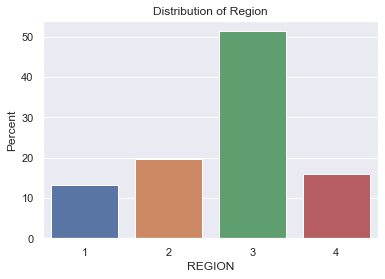

In [47]:
ACCIDENT_WEIGHT.REGION.value_counts()  #It means this whole data has 4 regions and they divided it into 1, 2, 3, 4

# shown in percentage
percentage = lambda i: len(i) / float(len(ACCIDENT_WEIGHT)) * 100

ax = sns.barplot(x='REGION', y='REGION',data=ACCIDENT_WEIGHT, estimator=percentage)
ax.set(title = "Distribution of Region", ylabel="Percent")
plt.show()

#1 Northeast (PA, NJ, NY, NH, VT, RI, MA, ME, CT),
#2 Midwest (OH, IN, IL, MI, WI, MN, ND, SD, NE, IA, MO, KS),
#3 South (MD, DE, DC, WV, VA, KY, TN, NC, SC, GA, FL, AL, MS, LA, AR, OK, TX),
#4 West (MT, ID, WA, OR, CA, NV, NM, AZ, UT, CO, WY, AK, HI)

The graph above (No of accident vs Region) telling us that Region 3 has the highest number of accident incidents which includes South part of USA (MD, DE, DC, WV, VA, KY, TN, NC, SC, GA, FL, AL, MS, LA, AR, OK, TX)

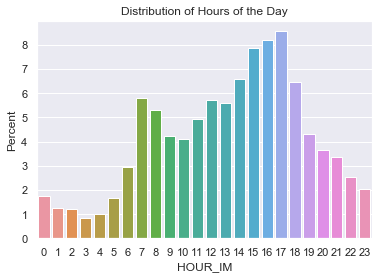

In [48]:
percentage = lambda i: len(i) / float(len(ACCIDENT_WEIGHT)) * 100

ax = sns.barplot(x='HOUR_IM', y='HOUR_IM',data=ACCIDENT_WEIGHT, estimator=percentage)
ax.set(title = "Distribution of Hours of the Day", ylabel="Percent")
plt.show()

At 5PM we had highest number of accident incident whereas at 3 AM in the morning had the lowest

Maximum number of accidents happened between 3 to 6 PM of the day.This is often because of the high volume of vehicles on the road
Question would be number of injury due to this accident incident follows the same trend?

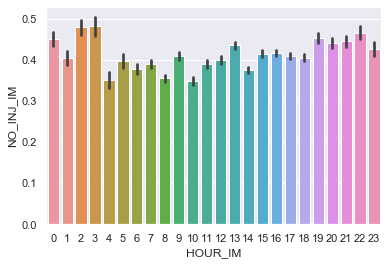

In [49]:
#Traffic Crashes and Injuries by Hour of the Day

ax = sns.barplot(x="HOUR_IM", y="NO_INJ_IM", data=ACCIDENT_WEIGHT)  
#Number of injury vs Hour of the day

The graph shows the number of injury does not change much at different hours of the day 

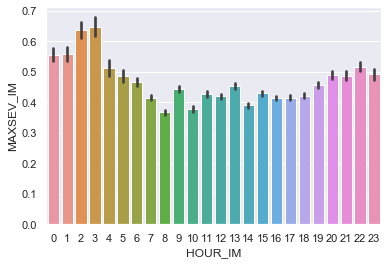

In [50]:
#Maximum severity vs Hour of the day
#0:No Apparent Injury | 1:Possible Injury | 2: Suspected Minor Injury | 3：Suspected Serious Injury | 4：Fatal
ax = sns.barplot(x="HOUR_IM", y="MAXSEV_IM", data=ACCIDENT_WEIGHT[ACCIDENT_WEIGHT.MAXSEV_IM<=4]) 

The graph shows an opposite trend with the number of the accidents at the different times of a day, which mean the accidents happeded from the midnight to early morning are most dangerous.

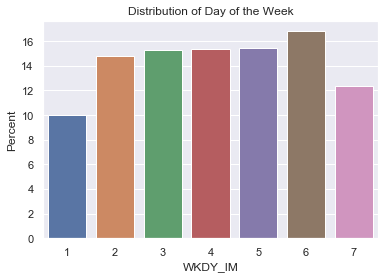

In [51]:
#Traffic Crashes and Injuries by Day of the Week
percentage = lambda i: len(i) / float(len(ACCIDENT_WEIGHT)) * 100

ax = sns.barplot(x='WKDY_IM', y='WKDY_IM',data=ACCIDENT_WEIGHT, estimator=percentage)
ax.set(title = "Distribution of Day of the Week", ylabel="Percent")
plt.show()

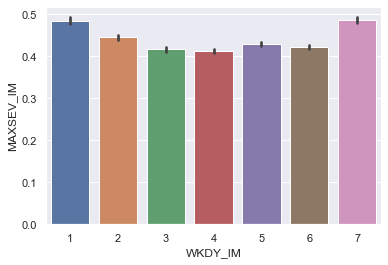

In [52]:
#Maximum severity vs Day of the Week
ax = sns.barplot(x="WKDY_IM", y="MAXSEV_IM", data=ACCIDENT_WEIGHT[ACCIDENT_WEIGHT.MAXSEV_IM<=4]) 

Graphs show that Sunday and Monday have the least number of accidents, nevertheless, accidents on Monday and Sunday are most dangerous.

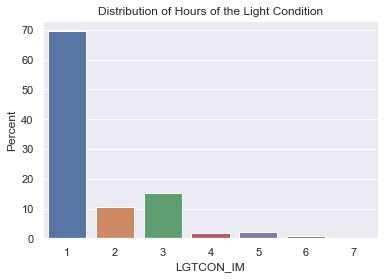

In [53]:
ACCIDENT_WEIGHT.LGTCON_IM.value_counts() #1 is daylight. most of the incident happened during daylight
percentage = lambda i: len(i) / float(len(ACCIDENT_WEIGHT)) * 100

ax = sns.barplot(x='LGTCON_IM', y='LGTCON_IM',data=ACCIDENT_WEIGHT, estimator=percentage)
ax.set(title = "Distribution of Hours of the Light Condition", ylabel="Percent")
plt.show()

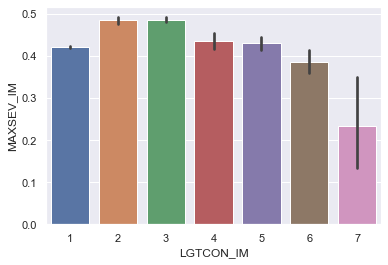

In [54]:
#Maximum severity vs Light Condition
ax = sns.barplot(x="LGTCON_IM", y="MAXSEV_IM", data=ACCIDENT_WEIGHT[ACCIDENT_WEIGHT.MAXSEV_IM<=4])
#1: dayligh | 2: Dark – Not Lighted | 3:Dark – Lighted | 4: Dawn |  5: Dust | 6: Dark – Unknown Lighting | 7: Other

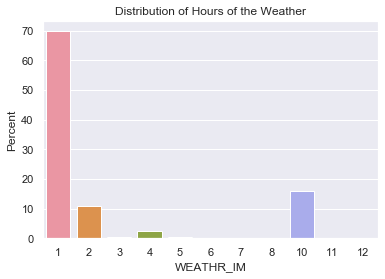

In [55]:
ACCIDENT_WEIGHT.WEATHER.value_counts() 
percentage = lambda i: len(i) / float(len(ACCIDENT_WEIGHT)) * 100

ax = sns.barplot(x='WEATHR_IM', y='WEATHR_IM',data=ACCIDENT_WEIGHT, estimator=percentage)
ax.set(title = "Distribution of Hours of the Weather", ylabel="Percent")
plt.show()

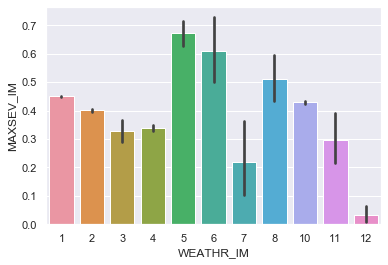

In [56]:
ax = sns.barplot(x="WEATHR_IM", y="MAXSEV_IM", data=ACCIDENT_WEIGHT[ACCIDENT_WEIGHT.MAXSEV_IM<=4])
#1:Clear | 2:Rain | 3:Sleet or Hail | 4:Snow | 5:Fog, Smog, Smoke | 6:Severe Crosswinds | 7: Blowing Sand, Soil, Dirt
# 8：Other| 10: Cloudy | 11: Blowing Snow | 12: Freezing Rain or Drizzle

When looking at the weather condition and the light condition, we see that most accidents happens during the sunny day and the daytime. However, this is becaues there are much more cars during the daytime and much more sunny days than other weather. So we look at the relationship between the maximum injury severity and the weather or light condition. The graphs show that when it's dark or foggy, the accidents are most dangerous.

Next question would be at night time what could be the reason of this large number of injured people? Is it due to the driver was drunk?


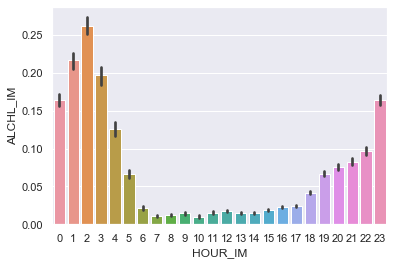

In [93]:
ACCIDENT_WEIGHT.ALCHL_IM.replace({2: 0}, inplace=True)
sns.barplot(x="HOUR_IM", y="ALCHL_IM",data=ACCIDENT_WEIGHT)

Grah shows that the accidents happened between 7pm and 5am are more likely to be involved with alcohol. More than 1/4 of the accdents happens at 2am are invloved with alcohol.

Let's see how the maximum injury severity is related to the alcohol involvement.

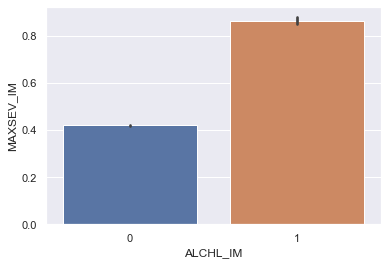

In [58]:
ax = sns.barplot(x="ALCHL_IM", y="MAXSEV_IM", data=ACCIDENT_WEIGHT[ACCIDENT_WEIGHT.MAXSEV_IM<=4])

It's clearly that the accidents with alcohol invloved are more likely to have injury.

Now let's look at the how the first harmful event related to the maximum injury severity.
There are four primary categories in the first harmful events, and many secondary categories, so we choose those first harmful events whose frequencies are larger than 0.007:
                      #(Collision with)
    #12    0.703722    Motor Vehicle In-Transport  
    #14    0.053320    Parked Motor Vehicle  
    #11    0.046306    Live Animal  
    #34    0.020996    Ditch  
    #30    0.017158    Utility Pole/Light Support  
    #42    0.016324    Tree (Standing Only)  
    #33    0.013827    Curb  
    #1     0.013602    (Non-Collision) Rollover/Overturn  
    #24    0.012516    Guardrail Face  
    #8     0.010565    Pedestrian  
    #59    0.010024    Traffic Sign Support  
    #38    0.008022    Fence  
    #35    0.007413    Embankment  
    #9     0.007281    Pedalcyclist  
    #25    0.007215    Concrete Traffic Barrier  

In [59]:
a = ACCIDENT_WEIGHT.EVENT1_IM.value_counts()
a/len(ACCIDENT_WEIGHT)

12    0.703722
14    0.053320
11    0.046306
34    0.020996
30    0.017158
42    0.016324
33    0.013827
1     0.013602
24    0.012516
8     0.010565
59    0.010024
38    0.008022
35    0.007413
9     0.007281
25    0.007215
18    0.006133
53    0.005681
43    0.005014
54    0.003245
31    0.003187
57    0.003165
32    0.003150
52    0.002915
39    0.002516
40    0.001589
19    0.001565
23    0.001144
2     0.000970
7     0.000739
46    0.000735
41    0.000696
15    0.000644
26    0.000642
93    0.000619
51    0.000611
48    0.000611
50    0.000607
5     0.000597
58    0.000574
91    0.000559
20    0.000508
44    0.000502
16    0.000487
45    0.000479
72    0.000427
17    0.000392
3     0.000272
21    0.000256
73    0.000227
6     0.000126
10    0.000120
55    0.000006
Name: EVENT1_IM, dtype: float64

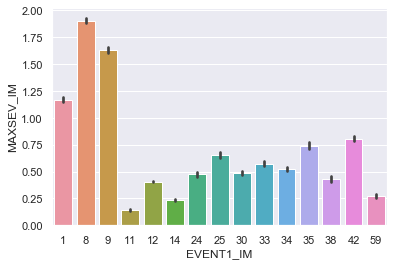

In [94]:
ACCIDENT_WEIGHT = ACCIDENT_WEIGHT.loc[ACCIDENT_WEIGHT['EVENT1_IM'].isin([12,14,11,34,30,42,33,1,24,8,59,38,35,9,25])]
ax = sns.barplot(x="EVENT1_IM", y="MAXSEV_IM", data=ACCIDENT_WEIGHT[ACCIDENT_WEIGHT.MAXSEV_IM<=4])

The graph shows that the accidents with rollover/overturn, collision with pedestrian or pedalcyclist are most dangerous, while the collisions with live animal, parked vehicle or traffic sigh are relatively safe.

Now let's look at the how the manner of collision related to the maximum injury severity.
    # 0 Not Collision with Motor Vehicle in Transport
    # 1 Front-to-Rear
    # 2 Front-to-Front
    # 6 Angle
    # 7 Sideswipe, Same Direction
    # 8 Sideswipe, Opposite Direction
    # 9 Rear-to-Side
    # 10 Rear-to-Rear
    # 11 Other

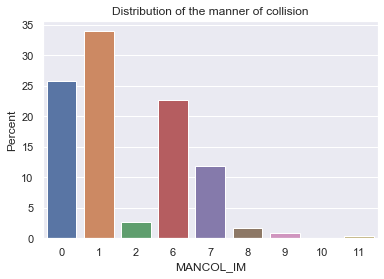

In [64]:
percentage = lambda i: len(i) / float(len(ACCIDENT_WEIGHT)) * 100

ax = sns.barplot(x='MANCOL_IM', y='MANCOL_IM',data=ACCIDENT_WEIGHT, estimator=percentage)
ax.set(title = "Distribution of the manner of collision", ylabel="Percent")
plt.show()

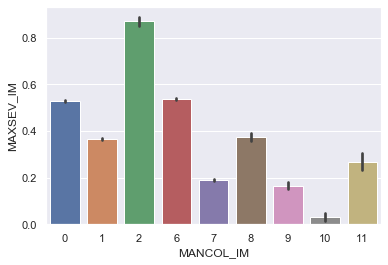

In [63]:
ax = sns.barplot(x="MANCOL_IM", y="MAXSEV_IM", data=ACCIDENT_WEIGHT[ACCIDENT_WEIGHT.MAXSEV_IM<=4])

Graphs show that Front-to-Front collision happens rarely, but it is extremely dangerous. Not Collision with Motor Vehicle in Transport is also dangerous because it may inlove rollover/overturn, collision with pedestrian or pedalcyclist.

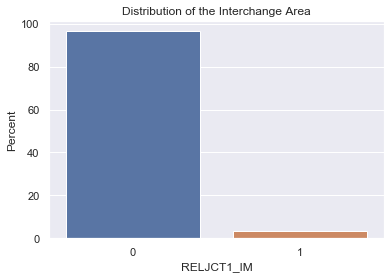

In [67]:
percentage = lambda i: len(i) / float(len(ACCIDENT_WEIGHT)) * 100

ax = sns.barplot(x='RELJCT1_IM', y='RELJCT1_IM',data=ACCIDENT_WEIGHT, estimator=percentage)
ax.set(title = "Distribution of the Interchange Area", ylabel="Percent")
plt.show()

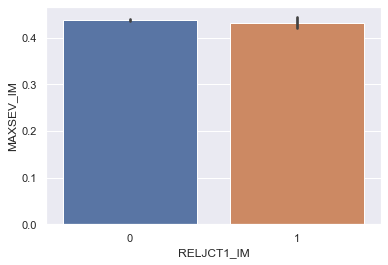

In [66]:
ax = sns.barplot(x="RELJCT1_IM", y="MAXSEV_IM", data=ACCIDENT_WEIGHT[ACCIDENT_WEIGHT.MAXSEV_IM<=4])

In [ ]:
Accidents happen within interchange area or not does not change the maximum injury severity very much.

Now let's look at the how the accidents location related to the maximum injury severity.
# 1 Non-Junction
# 2 Intersection
# 3 Intersection Related
# 4 Driveway Access
# 5 Entrance/Exit Ramp Related
# 6 Railway Grade Crossing
# 7 Crossover Related
# 8 Driveway Access Related
# 16 Shared-Use Path Crossing
# 17 Acceleration/Deceleration Lane
# 18 Through Roadway
# 19 Other Location Within Interchange Area
# 20 Entrance/Exit Ramp

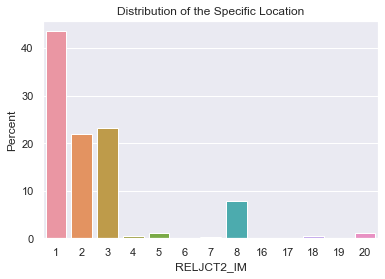

In [68]:
percentage = lambda i: len(i) / float(len(ACCIDENT_WEIGHT)) * 100

ax = sns.barplot(x='ax = sns.barplot(x="RELJCT1_IM", y="MAXSEV_IM", data=ACCIDENT_WEIGHT[ACCIDENT_WEIGHT.MAXSEV_IM<=4])', y='RELJCT2_IM',data=ACCIDENT_WEIGHT, estimator=percentage)
ax.set(title = "Distribution of the Specific Location", ylabel="Percent")
plt.show()

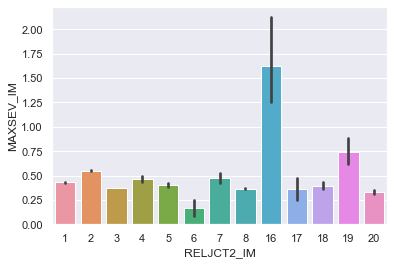

In [69]:
ax = sns.barplot(x="RELJCT2_IM", y="MAXSEV_IM", data=ACCIDENT_WEIGHT[ACCIDENT_WEIGHT.MAXSEV_IM<=4])

Accidents happen at the ntersection are more dangerous. Category 16 is very high, but the reason may be the lack of data.

In [ ]:
             Objective 2: Build a model to predict the maximum injury severity in an accident

In [95]:
#data pre-processing
ACCIDENT_WEIGHT.shape

(459380, 51)

In [96]:
ACCIDENT_WEIGHT = ACCIDENT_WEIGHT[['CASENUM','VE_FORMS','PEDS','PERMVIT','WKDY_IM', 'HOUR_IM', 'EVENT1_IM', 'MANCOL_IM', 'RELJCT1_IM', 'RELJCT2_IM',
       'LGTCON_IM', 'WEATHR_IM', 'MAXSEV_IM', 'NO_INJ_IM', 'ALCHL_IM']]

#CASENUM: CASE ID 
#VE_FORMS: Number of Motor Vehicles in Transport involved in the crash
#PEDS: Number of Persons Not in Motor Vehicles
#PERMVIT: Number of Persons in Motor Vehicles in Transport
#WKDY_IM: Imputed Day of Week
#HOUR_IM: Imputed Hour of Crash
#EVENT1_IM: Imputed First Harmful Event
#MANCOL_IM: Imputed Manner of Collision
#RELJCT1_IM: Imputed Relation to Junction- Within Interchange Area
#RELJCT2_IM: Imputed Relation to Junction- Specific Location
#LGTCON_IM: Imputed Light Condition
#WEATHR_IM: Imputed Atmospheric Conditions
#MAXSEV_IM: Imputed Maximum Injury Severity in Crash
#NO_INJ_IM: Imputed Number Injured in Crash
#ALCHL_IM: Imputed Alcohol Involved in Crash

In [97]:
ACCIDENT_WEIGHT = ACCIDENT_WEIGHT.loc[ACCIDENT_WEIGHT.MAXSEV_IM<=4]

In [98]:
ACCIDENT_WEIGHT.columns

Index(['CASENUM', 'VE_FORMS', 'PEDS', 'PERMVIT', 'WKDY_IM', 'HOUR_IM',
       'EVENT1_IM', 'MANCOL_IM', 'RELJCT1_IM', 'RELJCT2_IM', 'LGTCON_IM',
       'WEATHR_IM', 'MAXSEV_IM', 'NO_INJ_IM', 'ALCHL_IM'],
      dtype='object')

 Transform categorical variablesinto dummy binary variables.

In [99]:
ACCIDENT_WEIGHT_DUMMY = ACCIDENT_WEIGHT[['VE_FORMS', 'PEDS', 'PERMVIT', 'WKDY_IM', 'HOUR_IM',
       'EVENT1_IM', 'MANCOL_IM', 'RELJCT1_IM', 'RELJCT2_IM', 'LGTCON_IM', 'WEATHR_IM', 'MAXSEV_IM', 'ALCHL_IM']]
ACCIDENT_WEIGHT_DUMMY = pd.get_dummies(data = ACCIDENT_WEIGHT_DUMMY, columns = ['WKDY_IM', 'HOUR_IM',
       'EVENT1_IM', 'MANCOL_IM', 'RELJCT1_IM', 'RELJCT2_IM', 'LGTCON_IM', 'WEATHR_IM']).copy()
ACCIDENT_WEIGHT_DUMMY.shape  # Totally 92 variables

(457513, 93)

In [100]:
ACCIDENT_WEIGHT_DUMMY.corr()['MAXSEV_IM'].sort_values()

MANCOL_IM_7    -0.114053
EVENT1_IM_11   -0.084853
EVENT1_IM_12   -0.068163
MANCOL_IM_1    -0.064230
EVENT1_IM_14   -0.061800
                  ...   
EVENT1_IM_1     0.111218
EVENT1_IM_9     0.131632
EVENT1_IM_8     0.195398
PEDS            0.234219
MAXSEV_IM       1.000000
Name: MAXSEV_IM, Length: 93, dtype: float64

we added auxiliary file PER_AUX.csv, ACC_AUX.csv and VEH_AUX.csv to analyse data. 

In [4]:
# Read in data
PERSON = pd.read_csv('PERSON.csv')
PER_AUX = pd.read_csv('PER_AUX.csv')
# PER_AUX is the auxiliary file of the 'PERSON' file

Firstly, we use PERSON file to calculate the injury rate and death rate, since this datasets contain the injury information for every individual.

In [5]:
PER_AUX.shape

(120230, 20)

 Merge with PERSON file

In [6]:
PER_AUX = pd.merge(PER_AUX,PERSON)
PER_AUX.shape

(120230, 70)

In [7]:
PER_AUX.columns

Index(['A_AGE1', 'A_AGE2', 'A_AGE3', 'A_AGE4', 'A_AGE5', 'A_AGE6', 'A_AGE7',
       'A_AGE8', 'A_AGE9', 'CASENUM', 'VEH_NO', 'PER_NO', 'WEIGHT', 'YEAR',
       'A_PTYPE', 'A_RESTUSE', 'A_HELMUSE', 'A_EJECT', 'A_PERINJ', 'A_LOC',
       'VE_FORMS', 'REGION', 'PSU', 'PJ', 'PSU_VAR', 'URBANICITY', 'STRATUM',
       'STR_VEH', 'MONTH', 'HOUR', 'MINUTE', 'HARM_EV', 'MAN_COLL', 'SCH_BUS',
       'MAKE', 'BODY_TYP', 'MOD_YEAR', 'MAK_MOD', 'TOW_VEH', 'SPEC_USE',
       'EMER_USE', 'ROLLOVER', 'IMPACT1', 'FIRE_EXP', 'AGE', 'SEX', 'PER_TYP',
       'INJ_SEV', 'SEAT_POS', 'REST_USE', 'REST_MIS', 'AIR_BAG', 'EJECTION',
       'DRINKING', 'ALC_STATUS', 'ATST_TYP', 'ALC_RES', 'DRUGS', 'HOSPITAL',
       'P_SF1', 'P_SF2', 'P_SF3', 'LOCATION', 'SEX_IM', 'INJSEV_IM',
       'EJECT_IM', 'PERALCH_IM', 'SEAT_IM', 'AGE_IM', 'PSUSTRAT'],
      dtype='object')

 pick up useful variables

In [8]:
PER_AUX = PER_AUX[['A_AGE1', 'A_AGE2', 'A_AGE3', 'A_AGE4', 'A_AGE5', 'A_AGE6', 'A_AGE7','A_AGE8',
       'A_AGE9', 'CASENUM', 'VEH_NO', 'PER_NO', 'WEIGHT', 'YEAR', 'A_RESTUSE','A_HELMUSE',
       'A_EJECT', 'A_PERINJ', 'A_LOC','PER_TYP', 'SEX_IM', 'INJSEV_IM', 'PERALCH_IM']]

PER_AUX.shape

(120230, 23)

Explanations of variables
A_AGE1 to A_AGE9 are different divisions of age, here we choose age group 1
A_AGE1: AGE GROUP 1:  
        # 1: 0-15 | 2: 16-24 | 3: 25-54 | 4: 55+ 
CASENUM: CASE ID, not a variable
VEH_NO: The serial number of the vehicle in this case 
PER_NO: The serial number of person in this case
WEIGHT: WEIGHT of the case, not a variable
YEAR: All cases happened in 2018, not a variable
 *** A_RESTUSE: Restraint use:
        # 1: Restraint used | 2: Restraint not used | 3: Unknown
 *** A_HELMUSE: Helmet use:
        # 1: Helmeted | 2: Not helmeted | 3: Unknown
    # ***(It should be very careful when using A_RESTUSE and A_HELMUSE,
    # ***A_RESTUSE only applicable for motor vehicles except motorcyclists, A_HELMUSE only applicable for motorcyclists,
    # ***so one need to combine VEH_AUX datasets to include body types to analyses them respectively. )
A_EJECT: Ejection:
        # 1: Not ejected | 2: Ejected
A_PERINJ: Person injury type
        # 2: Incapacitating injured | 3: Nonincapacitating injured | 4: Other injured| 5: Not injured| 7: fatal
        # ***(Since there are lots of cases were divided into type 4: other injured, makes it hard to tell how serve the injury is,
        # *** so we are going to combine the INJ_SEV data from the PERSON file, which is more clear)
A_LOC: Non-motorist location:
        # 1: Not Applicable (Occupants) | 2: Within an intersection | 3: Non-intersection | 4: Other Location | 5: Unknown 
        # Since this variable is only applicable for the pedestrians, so we will exclude it
PER_TYP: Person Type
        # MOTORISTS：
            # 1 Driver of a Motor Vehicle in Transport
            # 2 Passenger of a Motor Vehicle in Transport
            # 9 Unknown Occupant Type in a Motor Vehicle in Transport
        # NON-MOTORISTS-OCCUPANT：
            # 3 Occupant of a Motor Vehicle Not in Transport
            # 4 Occupant of a Non-Motor Vehicle Transport Device
        # NON-MOTORISTS-NON-OCCUPANT：
            # 5 Pedestrian
            # 6 Bicyclist
            # 7 Other Cyclist
            # 8 Persons on Personal Conveyances
            # 10 Persons in or on Buildings
SEX_IM: Sex: 
    # 1: Male | 2: Female  
INJSEV_IM: 
    # 0: No Apparent Injury  
    # 1: Possible Injury   
    # 2: Suspected Minor Injury  
    # 3: Suspected Serious Injury  
    # 4: Fatal Injury  
    # 5: Injured, Severity Unknown  
    # 6: Died Prior to Crash
PERALCH_IM: Alcohol involvement: 0: No | 1: Yes

In [9]:
PER_AUX.INJSEV_IM.value_counts()

0    85290
1    17756
2     9887
3     5972
4      962
5      358
6        5
Name: INJSEV_IM, dtype: int64

Classify INJ_SEV into 3 categories: 0: No injury/1: Injury/ 2: Fatal injury


In [10]:
PER_AUX.loc[PER_AUX['INJSEV_IM'] == 1,'INJSEV_IM']= 0
PER_AUX.loc[PER_AUX['INJSEV_IM'] == 2,'INJSEV_IM']= 1
PER_AUX.loc[PER_AUX['INJSEV_IM'] == 3,'INJSEV_IM']= 1
PER_AUX.loc[PER_AUX['INJSEV_IM'] == 5,'INJSEV_IM']= 1
PER_AUX.loc[PER_AUX['INJSEV_IM'] == 4,'INJSEV_IM']= 2
PER_AUX.loc[PER_AUX['INJSEV_IM'] == 6,'INJSEV_IM']= 2
PER_AUX.INJSEV_IM.value_counts()

0    103046
1     16217
2       967
Name: INJSEV_IM, dtype: int64

In [11]:
PER_AUX.PER_TYP.value_counts()

1     85916
2     29820
5      2444
6      1433
3       449
8       123
9        38
10        4
7         3
Name: PER_TYP, dtype: int64

Drop PER_TYP = 3(Occupant of a Motor Vehicle Not in Transport)/7(Other Cyclist)/8(Persons on Personal Conveyances)/9(Unknown Occupant Type in a Motor Vehicle in Transport)/10(Persons in or on Buildings), since we focus on the people in transport

In [12]:
PER_AUX=PER_AUX[~PER_AUX['PER_TYP'].isin([3])]
PER_AUX=PER_AUX[~PER_AUX['PER_TYP'].isin([7])]
PER_AUX=PER_AUX[~PER_AUX['PER_TYP'].isin([8])]
PER_AUX=PER_AUX[~PER_AUX['PER_TYP'].isin([9])]
PER_AUX=PER_AUX[~PER_AUX['PER_TYP'].isin([10])]
PER_AUX.shape

(119613, 23)

Transform variables(age, sex, ejection,person type, alcohol invovement) into dummy variables

In [13]:
PER_AUX_DUMMY = PER_AUX[['A_AGE1','CASENUM','VEH_NO', 'PER_NO', 'WEIGHT', 'YEAR',
       'A_RESTUSE', 'A_HELMUSE', 'A_EJECT', 'A_LOC', 'PER_TYP','SEX_IM', 'INJSEV_IM','PERALCH_IM']]
PER_AUX_DUMMY = pd.get_dummies(data = PER_AUX_DUMMY, columns = ['A_EJECT','SEX_IM','PERALCH_IM'],drop_first = True).copy()
PER_AUX_DUMMY = pd.get_dummies(data = PER_AUX_DUMMY, columns = ['A_AGE1','PER_TYP']).copy()
PER_AUX_DUMMY.columns

Index(['CASENUM', 'VEH_NO', 'PER_NO', 'WEIGHT', 'YEAR', 'A_RESTUSE',
       'A_HELMUSE', 'A_LOC', 'INJSEV_IM', 'A_EJECT_2', 'SEX_IM_2',
       'PERALCH_IM_1', 'A_AGE1_1', 'A_AGE1_2', 'A_AGE1_3', 'A_AGE1_4',
       'PER_TYP_1', 'PER_TYP_2', 'PER_TYP_5', 'PER_TYP_6'],
      dtype='object')

Change variable names

In [14]:
PER_AUX_DUMMY.columns=['CASENUM','VEH_NO','PER_NO','WEIGHT','YEAR','A_RESTUSE_cars','A_HELMUSE_motorcyclists', 'A_LOC_nonmotorists','INJSEV_IM',
                       'Ejected','Female','Alcohol','Age_0_15','Age_16_24','Age_25_54','Age_55_More','Driver','Passenger','Pedestrian','Bicyclist'] 
PER_AUX_DUMMY.shape

(119613, 20)

In [16]:
PER_AUX_DUMMY.describe().T

,count,mean,std,min,25%,50%,75%,max
CASENUM,119613.0,2.018009e+11,236136.180449,2.018004e+11,2.018007e+11,2.018009e+11,2.018011e+11,2.018014e+11
VEH_NO,119613.0,1.482013e+00,0.711741,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.500000e+01
PER_NO,119613.0,1.383462e+00,0.816647,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.500000e+01
WEIGHT,119613.0,1.347980e+02,75.947523,1.208642e+01,6.778165e+01,1.595485e+02,1.749518e+02,5.860725e+02
YEAR,119613.0,2.018000e+03,0.000000,2.018000e+03,2.018000e+03,2.018000e+03,2.018000e+03,2.018000e+03
A_RESTUSE_cars,119613.0,1.283397e+00,0.663754,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00
A_HELMUSE_motorcyclists,119613.0,2.070653e+00,0.402292,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00
A_LOC_nonmotorists,119613.0,1.065026e+00,0.384073,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00
INJSEV_IM,119613.0,1.507027e-01,0.379598,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
Ejected,119613.0,3.511324e-03,0.059153,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


Now we want to build a model to predict the injury state of the individual  
Merge PERSON_STATE with ACC_AUX to get the accident information  
Read in ACC_AUX

In [17]:
ACC_AUX = pd.read_csv('ACC_AUX.csv')
ACC_AUX = ACC_AUX[['CASENUM', 'A_INTSEC', 'A_TOD', 'A_DOW', 'A_CT', 'A_LT', 'A_MANCOL',
        'A_MC', 'A_SPCRA', 'A_PED', 'A_PEDAL', 'A_ROLL', 'A_D15_19', 'A_D65PLS']]

ACC_AUX.shape

(48443, 14)

Explainations of variables  
A_INTSEC: Intersection: 1: intersection | 2: Non-intersection   
A_TOD: Time of Day: 1: Daytime | 2: Nighttime   
A_DOW: Day of Week: 1: Weekday | 2: Weekend  
A_CT: Crash type: 1: Single-Vehicle Crash | 2: Two-Vehicle Crash | 3: More Than Two-Vehicle Crash  
A_MANCOL: Manner of collision: 1: Not Collision with the vehicles in transport | 2: Rear-End | 3: Head on | 4: Angle | 5: Sideswipe | 6: Other  
A_LT: Involving a Large Truck: 1: Large Truck involved | 2: Not  
A_MC: Involving a Motorcycle: 1: Motorcycle involved | 2: Not  
A_SPCRA: Involving speeding: 1: Speeding involved | 2: Not  
A_PED: Involving Pedestrain: 1: Pedestrain involved | 2: Not  
A_PEDAL: Involving Pedalcyclist: 1: Pedalcyclist involved | 2: Not  
A_ROLL: Involving a Rollover: 1: Rollover involved | 2: Not  
A_D15_19: Involving a Young Driver(15-19): 1: Yes | 2: No  
A_D65PLS: Involving an Older Driver(65+): 1:Yes | 2: No

Because we focus on injury and fatal condition, we drop the cases with no person involved

In [115]:
PER_AUX_DUMMY_A = PER_AUX_DUMMY[['CASENUM']]
ACC_AUX = pd.merge(ACC_AUX,PER_AUX_DUMMY_A)
ACC_AUX = ACC_AUX.drop_duplicates()
ACC_AUX.shape

(48420, 14)

Transform all variables above into dummy variables

In [116]:
ACC_AUX_DUMMY = pd.get_dummies(data = ACC_AUX, columns = ['A_INTSEC','A_TOD','A_DOW','A_LT','A_MC','A_SPCRA','A_PED','A_PEDAL','A_ROLL','A_D15_19','A_D65PLS','A_CT','A_MANCOL']).copy()
ACC_AUX_DUMMY.columns

Index(['CASENUM', 'A_INTSEC_1', 'A_INTSEC_2', 'A_TOD_1', 'A_TOD_2', 'A_DOW_1',
       'A_DOW_2', 'A_LT_1', 'A_LT_2', 'A_MC_1', 'A_MC_2', 'A_SPCRA_1',
       'A_SPCRA_2', 'A_PED_1', 'A_PED_2', 'A_PEDAL_1', 'A_PEDAL_2', 'A_ROLL_1',
       'A_ROLL_2', 'A_D15_19_1', 'A_D15_19_2', 'A_D65PLS_1', 'A_D65PLS_2',
       'A_CT_1', 'A_CT_2', 'A_CT_3', 'A_MANCOL_1', 'A_MANCOL_2', 'A_MANCOL_3',
       'A_MANCOL_4', 'A_MANCOL_5', 'A_MANCOL_6'],
      dtype='object')

In [117]:
ACC_AUX_DUMMY = ACC_AUX_DUMMY.drop(columns=['A_INTSEC_2','A_TOD_1','A_DOW_1','A_LT_2','A_MC_2','A_SPCRA_2','A_PED_2','A_PEDAL_2','A_ROLL_2','A_D15_19_2','A_D65PLS_2'])
ACC_AUX_DUMMY.columns

Index(['CASENUM', 'A_INTSEC_1', 'A_TOD_2', 'A_DOW_2', 'A_LT_1', 'A_MC_1',
       'A_SPCRA_1', 'A_PED_1', 'A_PEDAL_1', 'A_ROLL_1', 'A_D15_19_1',
       'A_D65PLS_1', 'A_CT_1', 'A_CT_2', 'A_CT_3', 'A_MANCOL_1', 'A_MANCOL_2',
       'A_MANCOL_3', 'A_MANCOL_4', 'A_MANCOL_5', 'A_MANCOL_6'],
      dtype='object')

Change names

In [118]:
ACC_AUX_DUMMY.columns=['CASENUM','Within_Intersection','Nighttime','Weekend','Large_Truck_involved','Motorcycle_involved','Speeding_involved',
                       'Pedestrain_involved','Pedalcyclist_involved','Rollover_involved','Young_Driver_involved','Older_Driver_involved','Single_Vehicle_Crash',
                       'Two_Vehicle_Crash','Two_More_Vehicles_Crash','No_collision','Rear_End_collision','Head_on_collision','Angle_collision',
                       'Sideswipe_collision','Other_collision']
ACC_AUX_DUMMY.shape

(48420, 21)

In [119]:
ACC_AUX_DUMMY.describe().T

,count,mean,std,min,25%,50%,75%,max
CASENUM,48420.0,2.018009e+11,238134.266397,2.018004e+11,2.018007e+11,2.018009e+11,2.018011e+11,2.018014e+11
Within_Intersection,48420.0,4.547295e-01,0.497952,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
Nighttime,48420.0,3.076415e-01,0.461522,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
Weekend,48420.0,2.821974e-01,0.450074,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
Large_Truck_involved,48420.0,8.438662e-02,0.277970,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Motorcycle_involved,48420.0,5.216853e-02,0.222369,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Speeding_involved,48420.0,1.069599e-01,0.309065,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Pedestrain_involved,48420.0,4.805865e-02,0.213892,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Pedalcyclist_involved,48420.0,2.903759e-02,0.167914,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Rollover_involved,48420.0,4.500207e-02,0.207311,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


Merge PER_AUX_DUMMY with ACC_AUX_DUMMY to get the accident information


In [120]:
PERSON_STATE = pd.merge(PER_AUX_DUMMY,ACC_AUX_DUMMY)
PERSON_STATE.reset_index(inplace = True)
PERSON_STATE.columns

Index(['index', 'CASENUM', 'VEH_NO', 'PER_NO', 'WEIGHT', 'YEAR',
       'A_RESTUSE_cars', 'A_HELMUSE_motorcyclists', 'A_LOC_nonmotorists',
       'INJSEV_IM', 'Ejected', 'Female', 'Alcohol', 'Age_0_15', 'Age_16_24',
       'Age_25_54', 'Age_55_More', 'Driver', 'Passenger', 'Pedestrian',
       'Bicyclist', 'Within_Intersection', 'Nighttime', 'Weekend',
       'Large_Truck_involved', 'Motorcycle_involved', 'Speeding_involved',
       'Pedestrain_involved', 'Pedalcyclist_involved', 'Rollover_involved',
       'Young_Driver_involved', 'Older_Driver_involved',
       'Single_Vehicle_Crash', 'Two_Vehicle_Crash', 'Two_More_Vehicles_Crash',
       'No_collision', 'Rear_End_collision', 'Head_on_collision',
       'Angle_collision', 'Sideswipe_collision', 'Other_collision'],
      dtype='object')

Create new columns: INJ: 0 means no injured or dead in crash, 1 means there is(including death)  
                    DEATH: 0 means no dead in crash, 1 means there is   
Combining INJ, DEATH with PERSON_STATE

In [121]:

def INJ(x):
    if (( x['INJSEV_IM'] == 1) | (x['INJSEV_IM'] == 2)):
        return(1)
    else:
        return(0)
    
def DEATH(x):
    if x['INJSEV_IM'] == 2:
        return(1)
    else:
        return(0)   

PERSON_STATE['INJ'] = PERSON_STATE.apply(lambda x:INJ(x),axis = 1)
PERSON_STATE['DEATH'] = PERSON_STATE.apply(lambda x:DEATH(x),axis = 1)

PERSON_STATE.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
index,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00,6.000000e+00,7.000000e+00,8.000000e+00,9.000000e+00,1.000000e+01,1.100000e+01,1.200000e+01,1.300000e+01,1.400000e+01,1.500000e+01,1.600000e+01,1.700000e+01,1.800000e+01,1.900000e+01
CASENUM,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11
VEH_NO,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00
PER_NO,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00
WEIGHT,1.871933e+02,1.871933e+02,1.871933e+02,1.871933e+02,1.497873e+02,1.497873e+02,1.497873e+02,7.642126e+01,7.642126e+01,7.642126e+01,2.652323e+02,2.652323e+02,7.813454e+01,7.813454e+01,7.813454e+01,2.652323e+02,2.652323e+02,2.652323e+02,7.496763e+01,7.496763e+01
YEAR,2.018000e+03,2.018000e+03,2.018000e+03,2.018000e+03,2.018000e+03,2.018000e+03,2.018000e+03,2.018000e+03,2.018000e+03,2.018000e+03,2.018000e+03,2.018000e+03,2.018000e+03,2.018000e+03,2.018000e+03,2.018000e+03,2.018000e+03,2.018000e+03,2.018000e+03,2.018000e+03
A_RESTUSE_cars,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
A_HELMUSE_motorcyclists,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
A_LOC_nonmotorists,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
INJSEV_IM,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


First we look at the Motorists:

In [122]:
PERSON_STATE_MOTORISTS = PERSON_STATE[(PERSON_STATE.Driver == 1) | (PERSON_STATE.Passenger == 1)]
PERSON_STATE_MOTORISTS.shape

(115736, 43)

Merge PERSON_STATE_MOTORISTS with VEH_ACC to get the vehicle information to tell if the person was on a car or a motorcycle  
Read in VEH_ACC

In [123]:
VEH_AUX = pd.read_csv('VEH_AUX.csv')
VEH_AUX.columns

Index(['YEAR', 'CASENUM', 'VEH_NO', 'WEIGHT', 'A_BODY', 'A_IMP1', 'A_VROLL',
       'A_SPVEH', 'A_MOD_YR'],
      dtype='object')

Explainations of variablesv
A_BODY: Vehicle Body Type: 1: Passenger Car | 2：Light Truck - Pickup | 3：Light Truck - Utility |  4：Light Truck - Van
                            # 5： Light Truck - Other | 6： Large Truck | 7: Motorcycle | 8: Bus | 9: Other/Unknown 
A_VROLL: Rollover: 1: Rollover | 2: No Rollover
A_SPVEH: Speeding Vehicle: 1: Speed Involved | 2: No Speed Involved

In [124]:
VEH_AUX = VEH_AUX.drop(columns=['A_IMP1','A_MOD_YR'])

Transform variables into dummy variables

In [125]:
VEH_AUX_DUMMY = pd.get_dummies(data = VEH_AUX, columns = ['A_BODY','A_VROLL','A_SPVEH']).copy()
VEH_AUX_DUMMY.columns

Index(['YEAR', 'CASENUM', 'VEH_NO', 'WEIGHT', 'A_BODY_1', 'A_BODY_2',
       'A_BODY_3', 'A_BODY_4', 'A_BODY_5', 'A_BODY_6', 'A_BODY_7', 'A_BODY_8',
       'A_BODY_9', 'A_VROLL_1', 'A_VROLL_2', 'A_SPVEH_1', 'A_SPVEH_2'],
      dtype='object')

In [126]:
VEH_AUX_DUMMY = VEH_AUX_DUMMY.drop(columns=['A_VROLL_2','A_SPVEH_2'])
VEH_AUX_DUMMY.columns

Index(['YEAR', 'CASENUM', 'VEH_NO', 'WEIGHT', 'A_BODY_1', 'A_BODY_2',
       'A_BODY_3', 'A_BODY_4', 'A_BODY_5', 'A_BODY_6', 'A_BODY_7', 'A_BODY_8',
       'A_BODY_9', 'A_VROLL_1', 'A_SPVEH_1'],
      dtype='object')

Change names

In [127]:
VEH_AUX_DUMMY.columns=['YEAR','CASENUM','VEH_NO','WEIGHT','Passenger_Car','Light_Truck_Pickup','Light_Truck_Utility','Light_Truck_Van',
                       'Light_Truck_Other','Large_Truck','Motorcycle','Bus','Other','Rollover','Speeding']

In [128]:
PERSON_STATE_MOTORISTS = pd.merge(PERSON_STATE_MOTORISTS,VEH_AUX_DUMMY)
PERSON_STATE_MOTORISTS.columns

Index(['index', 'CASENUM', 'VEH_NO', 'PER_NO', 'WEIGHT', 'YEAR',
       'A_RESTUSE_cars', 'A_HELMUSE_motorcyclists', 'A_LOC_nonmotorists',
       'INJSEV_IM', 'Ejected', 'Female', 'Alcohol', 'Age_0_15', 'Age_16_24',
       'Age_25_54', 'Age_55_More', 'Driver', 'Passenger', 'Pedestrian',
       'Bicyclist', 'Within_Intersection', 'Nighttime', 'Weekend',
       'Large_Truck_involved', 'Motorcycle_involved', 'Speeding_involved',
       'Pedestrain_involved', 'Pedalcyclist_involved', 'Rollover_involved',
       'Young_Driver_involved', 'Older_Driver_involved',
       'Single_Vehicle_Crash', 'Two_Vehicle_Crash', 'Two_More_Vehicles_Crash',
       'No_collision', 'Rear_End_collision', 'Head_on_collision',
       'Angle_collision', 'Sideswipe_collision', 'Other_collision', 'INJ',
       'DEATH', 'Passenger_Car', 'Light_Truck_Pickup', 'Light_Truck_Utility',
       'Light_Truck_Van', 'Light_Truck_Other', 'Large_Truck', 'Motorcycle',
       'Bus', 'Other', 'Rollover', 'Speeding'],
      dtype='ob

Focus on the motor vehicles excluding motorcycles

In [129]:
PERSON_STATE_CARS = PERSON_STATE_MOTORISTS[(PERSON_STATE_MOTORISTS.Motorcycle == 0) & (PERSON_STATE_MOTORISTS.Other == 0)]

In [130]:
pd.get_dummies(data = PERSON_STATE_CARS, columns = ['A_RESTUSE_cars']).copy()
PERSON_STATE_CARS = PERSON_STATE_CARS.drop(columns=['index','INJSEV_IM','VEH_NO', 'PER_NO', 'WEIGHT', 'YEAR','A_HELMUSE_motorcyclists','A_LOC_nonmotorists','Pedestrian', 'Bicyclist','Motorcycle','Other'])

We can see that rear-end-collsion have the smallest correlation with injury, but interestingly whether the viechel is in the intersection is not related to injury. Also, whether you are the passanger or driver is not related to injury.  It seems weenkend, angle collsion,nightime, speeding,head-on collsion have corrleation with injury. In addition, alcohol, ejection and rollover have obvious corrleation with injury.

In [131]:
PERSON_STATE_CARS.corr()['INJ'].sort_values()

Rear_End_collision        -0.113585
Two_Vehicle_Crash         -0.091226
Sideswipe_collision       -0.075152
Large_Truck               -0.051844
Pedestrain_involved       -0.045872
Pedalcyclist_involved     -0.039846
Motorcycle_involved       -0.036556
Within_Intersection       -0.035691
Age_0_15                  -0.033249
Other_collision           -0.028949
CASENUM                   -0.019065
Young_Driver_involved     -0.011684
Bus                       -0.011135
Large_Truck_involved      -0.010624
Light_Truck_Van           -0.006762
Age_25_54                 -0.002809
Light_Truck_Other         -0.002453
Driver                    -0.001728
Light_Truck_Utility       -0.001514
Light_Truck_Pickup         0.000588
Passenger                  0.001728
Age_16_24                  0.006954
Older_Driver_involved      0.011807
Two_More_Vehicles_Crash    0.012791
Age_55_More                0.019763
Female                     0.022104
Passenger_Car              0.027540
Weekend                    0

create heatmap with annotations

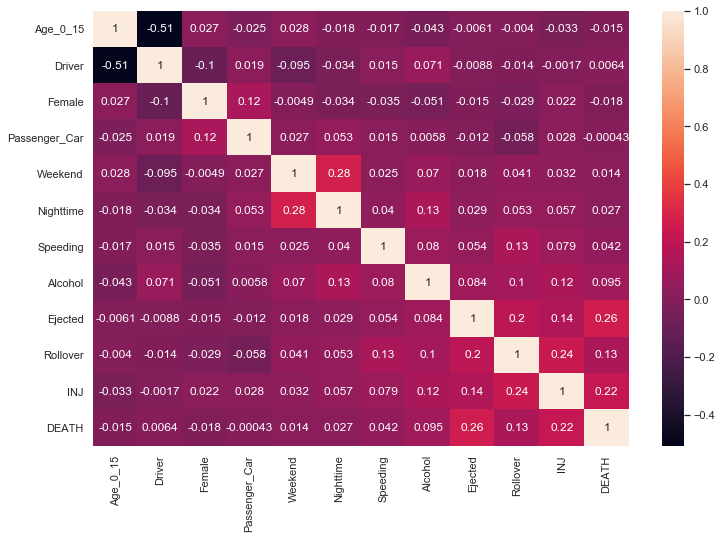

In [141]:
PERSON_STATE_CARS_heatmap = PERSON_STATE_CARS[['Age_0_15','Driver','Female','Passenger_Car','Weekend','Nighttime','Speeding',
                                              'Alcohol','Ejected','Rollover','INJ','DEATH']]
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(PERSON_STATE_CARS_heatmap.corr(), annot=True);

We pich up some representive varibles to get the heatmap. We can see that young age has negative correlation with driver, because they are illegal to drive the car. Interestingly, nighttime and weekend have strong correlation, because people often have fun at weekend night. In addition, Rollover and ejected are strongly related because it is possible for passengers to be ejected if the viechle is rollover. Also, the ejection has the highest correaltion with death at 0.26.

In the next week, we will build some models to predict the injury and death on certain conditions. Also, we will analyze the injury and death of motorcycle and pedestrain.

In [ ]:
#-----------------------------------------------------------------------------------------------------------
# neglect codes below this line, for the future use 

In [194]:
# Create new columns: INJ: 0 means no injured or dead in crash, 1 means there is
                    # DEATH: 0 means no dead in crash, 1 means there is 
caseid = PER_AUX.CASENUM.unique()   # How many persons involved in a certain case
dict_injury = {}
dict_death = {}

for i in caseid:
    case = PER_AUX[PER_AUX.CASENUM == i]
    caseunique = case.INJSEV_IM.unique()  
    if (1 in caseunique) or (2 in caseunique) :
        dict_injury[i] = 1
    else:
        dict_injury[i] = 0
    if 2 in caseunique:
        dict_death[i] = 1
    else:
        dict_death[i] = 0

In [195]:
# Create new columns: death rate and injury rate for each case
counts = PER_AUX.CASENUM.value_counts()   # How many persons involved in a certain case
dict_injury_rate = {}
dict_death_rate = {}

for i, v in counts.items():
    total = v  # Total people involved in the case i
    case = PER_AUX[PER_AUX.CASENUM == i]
    counts_case = case.INJSEV_IM.value_counts()  # Counting number for each type in INJ_SER in the case i
    Death = pd.Series(counts_case,index=[2])[2]  # No. of the dead in the case i
    Injury = pd.Series(counts_case,index=[1])[1]  # No. of the injured in the case i
    INJ_RATE = Injury/total  # Injury rate of the case i 
    DEATH_RATE = Death/total  # Fatal rate of the case i
    dict_injury_rate[i] = INJ_RATE 
    dict_death_rate[i] = DEATH_RATE

In [196]:
# Combining INJ, DEATH, INJ_RATE and DEATH_RATE with PER_AUX
PER_AUX['INJ'] = PER_AUX['CASENUM'].apply(lambda x:dict_injury[x])
PER_AUX['DEATH'] = PER_AUX['CASENUM'].apply(lambda x:dict_death[x])
PER_AUX['INJ_RATE'] = PER_AUX['CASENUM'].apply(lambda x:dict_injury_rate[x])
PER_AUX['DEATH_RATE'] = PER_AUX['CASENUM'].apply(lambda x:dict_death_rate[x])

PER_AUX.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
A_AGE1,3.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,2.000000e+00,3.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,1.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00
A_AGE2,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,4.000000e+00,5.000000e+00,5.000000e+00,4.000000e+00,3.000000e+00,4.000000e+00,2.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,1.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
A_AGE3,9.000000e+00,8.000000e+00,8.000000e+00,1.100000e+01,7.000000e+00,9.000000e+00,9.000000e+00,7.000000e+00,6.000000e+00,7.000000e+00,5.000000e+00,9.000000e+00,1.100000e+01,9.000000e+00,3.000000e+00,8.000000e+00,1.000000e+01,9.000000e+00,1.100000e+01,9.000000e+00
A_AGE4,6.000000e+00,5.000000e+00,5.000000e+00,7.000000e+00,4.000000e+00,6.000000e+00,6.000000e+00,4.000000e+00,3.000000e+00,4.000000e+00,2.000000e+00,6.000000e+00,7.000000e+00,6.000000e+00,1.000000e+00,5.000000e+00,6.000000e+00,6.000000e+00,7.000000e+00,6.000000e+00
A_AGE5,6.000000e+00,5.000000e+00,5.000000e+00,8.000000e+00,4.000000e+00,6.000000e+00,6.000000e+00,4.000000e+00,3.000000e+00,4.000000e+00,2.000000e+00,6.000000e+00,8.000000e+00,6.000000e+00,1.000000e+00,5.000000e+00,7.000000e+00,6.000000e+00,8.000000e+00,6.000000e+00
A_AGE6,6.000000e+00,5.000000e+00,5.000000e+00,8.000000e+00,4.000000e+00,6.000000e+00,6.000000e+00,4.000000e+00,3.000000e+00,4.000000e+00,2.000000e+00,6.000000e+00,8.000000e+00,6.000000e+00,1.000000e+00,5.000000e+00,7.000000e+00,6.000000e+00,8.000000e+00,6.000000e+00
A_AGE7,8.000000e+00,7.000000e+00,7.000000e+00,1.000000e+01,6.000000e+00,8.000000e+00,8.000000e+00,6.000000e+00,5.000000e+00,6.000000e+00,4.000000e+00,8.000000e+00,1.000000e+01,8.000000e+00,3.000000e+00,7.000000e+00,9.000000e+00,8.000000e+00,1.000000e+01,8.000000e+00
A_AGE8,4.000000e+00,4.000000e+00,3.000000e+00,6.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00,3.000000e+00,2.000000e+00,3.000000e+00,1.000000e+00,5.000000e+00,6.000000e+00,4.000000e+00,1.000000e+00,4.000000e+00,6.000000e+00,5.000000e+00,6.000000e+00,4.000000e+00
A_AGE9,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
CASENUM,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11


In [197]:
# Filling the missing value in INJ_RATE and DEATH_RATE with 0
PER_AUX.INJ_RATE = PER_AUX.INJ_RATE.fillna(0)
PER_AUX.DEATH_RATE = PER_AUX.DEATH_RATE.fillna(0)

PER_AUX.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
A_AGE1,3.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,2.000000e+00,3.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,1.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00
A_AGE2,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,4.000000e+00,5.000000e+00,5.000000e+00,4.000000e+00,3.000000e+00,4.000000e+00,2.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,1.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
A_AGE3,9.000000e+00,8.000000e+00,8.000000e+00,1.100000e+01,7.000000e+00,9.000000e+00,9.000000e+00,7.000000e+00,6.000000e+00,7.000000e+00,5.000000e+00,9.000000e+00,1.100000e+01,9.000000e+00,3.000000e+00,8.000000e+00,1.000000e+01,9.000000e+00,1.100000e+01,9.000000e+00
A_AGE4,6.000000e+00,5.000000e+00,5.000000e+00,7.000000e+00,4.000000e+00,6.000000e+00,6.000000e+00,4.000000e+00,3.000000e+00,4.000000e+00,2.000000e+00,6.000000e+00,7.000000e+00,6.000000e+00,1.000000e+00,5.000000e+00,6.000000e+00,6.000000e+00,7.000000e+00,6.000000e+00
A_AGE5,6.000000e+00,5.000000e+00,5.000000e+00,8.000000e+00,4.000000e+00,6.000000e+00,6.000000e+00,4.000000e+00,3.000000e+00,4.000000e+00,2.000000e+00,6.000000e+00,8.000000e+00,6.000000e+00,1.000000e+00,5.000000e+00,7.000000e+00,6.000000e+00,8.000000e+00,6.000000e+00
A_AGE6,6.000000e+00,5.000000e+00,5.000000e+00,8.000000e+00,4.000000e+00,6.000000e+00,6.000000e+00,4.000000e+00,3.000000e+00,4.000000e+00,2.000000e+00,6.000000e+00,8.000000e+00,6.000000e+00,1.000000e+00,5.000000e+00,7.000000e+00,6.000000e+00,8.000000e+00,6.000000e+00
A_AGE7,8.000000e+00,7.000000e+00,7.000000e+00,1.000000e+01,6.000000e+00,8.000000e+00,8.000000e+00,6.000000e+00,5.000000e+00,6.000000e+00,4.000000e+00,8.000000e+00,1.000000e+01,8.000000e+00,3.000000e+00,7.000000e+00,9.000000e+00,8.000000e+00,1.000000e+01,8.000000e+00
A_AGE8,4.000000e+00,4.000000e+00,3.000000e+00,6.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00,3.000000e+00,2.000000e+00,3.000000e+00,1.000000e+00,5.000000e+00,6.000000e+00,4.000000e+00,1.000000e+00,4.000000e+00,6.000000e+00,5.000000e+00,6.000000e+00,4.000000e+00
A_AGE9,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
CASENUM,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11,2.018004e+11


In [198]:
ACC_AUX = pd.read_csv('C:\\Users\\98699\\Desktop\\ce6800\\ce6800pj\\crash report sampling system 2018CSV\\ACC_AUX.csv')
# Combining INJ, DEATH, INJ_RATE and DEATH_RATE with ACC_AUX
ACC_AUX = ACC_AUX[['CASENUM', 'A_INTSEC', 'A_TOD', 'A_DOW', 'A_CT', 'A_LT', 'A_MANCOL',
        'A_MC', 'A_SPCRA', 'A_PED', 'A_PEDAL', 'A_ROLL', 'A_D15_19', 'A_D65PLS']]

ACC_AUX.shape

(48443, 14)

In [199]:
# Explainations of variables
# A_INTSEC: Intersection: 1: intersection | 2: Non-intersection 
# A_TOD: Time of Day: 1: Daytime | 2: Nighttime 
# A_DOW: Day of Week: 1: Weekday | 2: Weekend
# A_CT: Crash type: 1: Single-Vehicle Crash | 2: Two-Vehicle Crash | 3: More Than Two-Vehicle Crash
# A_MANCOL: Manner of collision: 1: Not Collision with the vehicles in transport | 2: Rear-End | 3: Head on | 4: Angle | 5: Sideswipe | 6: Other
# A_LT: Involving a Large Truck: 1: Large Truck involved | 2: Not
# A_MC: Involving a Motorcycle: 1: Motorcycle involved | 2: Not
# A_SPCRA: Involving speeding: 1: Speeding involved | 2: Not
# A_PED: Involving Pedestrain: 1: Pedestrain involved | 2: Not
# A_PEDAL: Involving Pedalcyclist: 1: Pedalcyclist involved | 2: Not
# A_ROLL: Involving a Rollover: 1: Rollover involved | 2: Not
# A_D15_19: Involving a Young Driver(15-19): 1: Yes | 2: No
# A_D65PLS: Involving an Older Driver(65+): 1:Yes | 2: No

In [200]:
# Combining the INJ_RATE and DEATH_RATE with the ACC_AUX
PER_AUX_A = PER_AUX[['CASENUM', 'INJ', 'DEATH', 'INJ_RATE', 'DEATH_RATE']]
ACC_AUX = pd.merge(ACC_AUX,PER_AUX_A)
ACC_AUX = ACC_AUX.drop_duplicates()
ACC_AUX.shape

(48426, 18)

In [246]:
# Transform variables into dummy variables
ACC_AUX_DUMMY = pd.get_dummies(data = ACC_AUX, columns = ['A_INTSEC','A_TOD','A_DOW','A_LT','A_MC','A_SPCRA','A_PED','A_PEDAL','A_ROLL','A_D15_19','A_D65PLS'],drop_first = True).copy()
ACC_AUX_DUMMY = pd.get_dummies(data = ACC_AUX_DUMMY, columns = ['A_CT','A_MANCOL']).copy()
ACC_AUX_DUMMY.columns

Index(['CASENUM', 'INJ', 'DEATH', 'INJ_RATE', 'DEATH_RATE', 'A_INTSEC_2',
       'A_TOD_2', 'A_DOW_2', 'A_LT_2', 'A_MC_2', 'A_SPCRA_2', 'A_PED_2',
       'A_PEDAL_2', 'A_ROLL_2', 'A_D15_19_2', 'A_D65PLS_2', 'A_CT_1', 'A_CT_2',
       'A_CT_3', 'A_MANCOL_1', 'A_MANCOL_2', 'A_MANCOL_3', 'A_MANCOL_4',
       'A_MANCOL_5', 'A_MANCOL_6'],
      dtype='object')

In [247]:
ACC_AUX_DUMMY.describe().T

,count,mean,std,min,25%,50%,75%,max
CASENUM,48426.0,2.018009e+11,238142.338109,2.018004e+11,2.018007e+11,2.018009e+11,2.018011e+11,2.018014e+11
INJ,48426.0,4.941973e-01,0.499971,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
DEATH,48426.0,1.835791e-02,0.134243,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
INJ_RATE,48426.0,2.984132e-01,0.362171,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e-01,1.000000e+00
DEATH_RATE,48426.0,1.076773e-02,0.087907,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
A_INTSEC_2,48426.0,5.452856e-01,0.497950,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
A_TOD_2,48426.0,3.077066e-01,0.461549,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
A_DOW_2,48426.0,2.822038e-01,0.450077,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
A_LT_2,48426.0,9.156238e-01,0.277954,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
A_MC_2,48426.0,9.478379e-01,0.222356,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [248]:
# Now we build a model to describe whether there will be injured or dead in a traffic accident
ACC_AUX_DUMMY.reset_index(inplace = True)

cv = KFold(n_splits=5, shuffle=True, random_state=0)
for train_index, test_index in cv.split(ACC_AUX_DUMMY):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))

TRAIN: 38740 TEST: 9686
TRAIN: 38741 TEST: 9685
TRAIN: 38741 TEST: 9685
TRAIN: 38741 TEST: 9685
TRAIN: 38741 TEST: 9685


In [259]:
## Define function
cv = KFold(n_splits=5, shuffle=True, random_state=4240)

## Create for-loop
for train_index, test_index in cv.split(ACC_AUX_DUMMY):

    ## Define training and test sets
    X_train = ACC_AUX_DUMMY.loc[train_index].drop(['CASENUM', 'INJ', 'DEATH', 'INJ_RATE', 'DEATH_RATE'], axis=1)
    y_train = ACC_AUX_DUMMY.loc[train_index]['INJ']
    X_test = ACC_AUX_DUMMY.loc[test_index].drop(['CASENUM', 'INJ', 'DEATH', 'INJ_RATE', 'DEATH_RATE'], axis=1)
    y_test = ACC_AUX_DUMMY.loc[test_index]['INJ']
        
    ## Fit model
    clf = LogisticRegression(max_iter = 1000)
    clf.fit(X_train, y_train)

    ## Generate predictions
    predicted = clf.predict(X_test)
    
    ## Compare to actual outcomes and return precision
    print('Precision: ', (round(precision_score(y_test, predicted)*100,1)))
    print(predicted)

Precision:  60.5
[0 0 1 ... 1 0 0]
Precision:  0.0
[0 0 0 ... 0 0 0]


C:\Users\98699\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision:  60.2
[0 0 0 ... 1 1 1]
Precision:  0.0
[0 0 0 ... 0 0 0]
Precision:  0.0
[0 0 0 ... 0 0 0]


C:\Users\98699\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\98699\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [239]:
ACC_AUX_DUMMY.corr()['INJ_RATE'].sort_values()

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [261]:
ACC_AUX_DUMMY.corr()['INJ'].sort_values()

A_PED_2      -0.225945
A_MC_2       -0.215410
A_PEDAL_2    -0.170021
A_MANCOL_5   -0.166394
A_CT_2       -0.160893
A_ROLL_2     -0.130933
A_MANCOL_2   -0.084593
A_MANCOL_6   -0.063287
A_SPCRA_2    -0.061614
A_INTSEC_2   -0.057629
A_D65PLS_2   -0.003007
index         0.014812
CASENUM       0.017129
A_D15_19_2    0.026068
A_DOW_2       0.044811
A_TOD_2       0.053511
A_MANCOL_4    0.063912
A_MANCOL_3    0.085388
A_CT_3        0.092779
A_LT_2        0.101684
A_CT_1        0.116284
A_MANCOL_1    0.121718
DEATH_RATE    0.123922
DEATH         0.138349
INJ_RATE      0.833584
INJ           1.000000
Name: INJ, dtype: float64

In [152]:
ACC_AUX.corr()['DEATH_RATE'].sort_values()

A_ROLL       -0.136836
A_CT         -0.089253
INJ_RATE     -0.054999
A_MC         -0.051398
A_SPCRA      -0.042493
A_PED        -0.038244
A_LT         -0.000870
A_D65PLS      0.001238
CASENUM       0.002275
A_PEDAL       0.007136
A_D15_19      0.013665
A_DOW         0.031197
A_TOD         0.054775
A_INTSEC      0.059360
DEATH_RATE    1.000000
Name: DEATH_RATE, dtype: float64

In [289]:
# Build a model to predict the injury state of the individual
PERSON_STATE = PER_AUX[['A_AGE1','CASENUM','VEH_NO', 'PER_NO', 'WEIGHT', 'YEAR',
       'A_RESTUSE', 'A_HELMUSE', 'A_EJECT', 'A_LOC', 'PER_TYP','SEX_IM', 'INJSEV_IM']]
PERSON_STATE.shape

(120230, 13)

In [290]:
# Merge with ACC_AUX_DUMMY to get the accident information
PERSON_STATE = pd.merge(PERSON_STATE,ACC_AUX_DUMMY)
PERSON_STATE.columns

In [293]:
PERSON_STATE.PER_TYP.value_counts()

1     85916
2     29820
5      2444
6      1433
3       449
8       123
9        38
10        4
7         3
Name: PER_TYP, dtype: int64

In [286]:
# First we look at the Motorists:
PERSON_STATE_Motor

(115774, 43)